In [39]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis

import requests # library to handle requests

import matplotlib.pyplot as plt # Matplotlib and associated plotting modules
%matplotlib inline

import folium # map rendering library

from bs4 import BeautifulSoup # library to handle data out of HTML

print('Libraries imported.')

Libraries imported.


## Scrape Singapore Planning Areas from Wikipedia

In [40]:
url = 'https://en.wikipedia.org/wiki/Planning_Areas_of_Singapore#List_of_Planning_Areas'

In [41]:
website_url = requests.get(url).text

In [42]:
soup = BeautifulSoup(website_url,'lxml')

In [43]:
table = soup.find('table', { 'class' : 'wikitable sortable'})

In [44]:
soup.title.string

'Planning Areas of Singapore - Wikipedia'

In [45]:
planning_areas = []
region = []

for row in table.findAll('tr'):
    cells=row.findAll('td')
    if len(cells)==9:
        planning_areas.append(cells[0].find(text=True))
        region.append(cells[5].find(text=True))

In [46]:
column_name = ['Planning Areas', 'Region', 'Latitude', 'Longitude']

sg = pd.DataFrame(columns = column_name)

sg.head(10)

,Planning Areas,Region,Latitude,Longitude


## Find Out Coordinates for each Planning Areas

In [47]:
import json # library to handle JSON files

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

print('Libraries imported.')

Libraries imported.


In [48]:
user = 'sg_explorer'

geolocator = Nominatim(user_agent= user)
sg_loc = geolocator.geocode('Singapore')
sg_lat = sg_loc.latitude
sg_long = sg_loc.longitude

print('The geographical coordinate of Singapore are {}, {}.'.format(sg_lat, sg_long))

The geographical coordinate of Singapore are 1.357107, 103.8194992.


In [49]:
#initiate empty list as placeholder

location = []
latitude = []
longitude = []

for data in range(0, len(planning_areas)):
    d = planning_areas[data]
    r = region[data]
    
    geolocator = Nominatim(user_agent = user)
    location = geolocator.geocode('{}, Singapore'.format(d))
    latitude = location.latitude
    longitude = location.longitude
    
    sg = sg.append({ 'Planning Areas' : d, 'Region' : r, 'Latitude' : latitude, 'Longitude' : longitude}, ignore_index = True)

In [50]:
sg.head(10)

,Planning Areas,Region,Latitude,Longitude
0,Ang Mo Kio,North-East,1.370080,103.849523
1,Bedok,East,1.323976,103.930216
2,Bishan,Central,1.350986,103.848255
3,Boon Lay,West,1.338550,103.705812
4,Bukit Batok,West,1.349057,103.749591
5,Bukit Merah,Central,1.270439,103.828318
6,Bukit Panjang,West,1.379149,103.761413
7,Bukit Timah,Central,1.354690,103.776372
8,Central Water Catchment,North,1.375708,103.801743
9,Changi,East,1.351080,103.990064


In [51]:
# Visualize Plot Map

map_sg = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, plan in zip(sg['Latitude'], sg['Longitude'], sg['Planning Areas']):
    label = '{}'.format(plan)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_sg)  
    
map_sg

## Exploring Top Areas Venues with Foursquare

In [52]:
# Foursquare Credentials

CLIENT_ID = '2CNEIAHO1AIQYNB5YBT2Z3SSC1EPCOW5FE53ZGM4GBMIPN0M' #  Foursquare ID
CLIENT_SECRET = 'OTADQTEKYXAWGPXLPXGKWWSH02KPD3XJLH4RQBY5P51U24O4' # Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 2CNEIAHO1AIQYNB5YBT2Z3SSC1EPCOW5FE53ZGM4GBMIPN0M
CLIENT_SECRET:OTADQTEKYXAWGPXLPXGKWWSH02KPD3XJLH4RQBY5P51U24O4


In [53]:
# Check first row of Planning Areas

sg.loc[0, 'Planning Areas']

'Ang Mo Kio'

In [54]:
# Check first row of Planning Areas coordinates

neigh_lat = sg.loc[0, 'Latitude']
neigh_long = sg.loc[0, 'Longitude']

neigh_name = sg.loc[0, 'Planning Areas']

print('Latitude and longitude values of {} are {}, {}.'.format(neigh_name, 
                                                               neigh_lat, 
                                                               neigh_long))

Latitude and longitude values of Ang Mo Kio are 1.3700803, 103.8495228.


In [55]:
# Getting top 10 venues in Ang Mo Kio Areas within radius 500m

search_query = 'venues'
radius = 500
LIMIT = 100

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neigh_lat, 
    neigh_long, 
    radius, 
    LIMIT)


url

'https://api.foursquare.com/v2/venues/explore?&client_id=2CNEIAHO1AIQYNB5YBT2Z3SSC1EPCOW5FE53ZGM4GBMIPN0M&client_secret=OTADQTEKYXAWGPXLPXGKWWSH02KPD3XJLH4RQBY5P51U24O4&v=20180605&ll=1.3700803,103.8495228&radius=500&limit=100'

In [56]:
# Getting json of the venues

results = requests.get(url).json()

In [57]:
# Create function to explore other areas

def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [58]:
# Get data of venues on each Planning Areas

sg_venues = getNearbyVenues(names = sg['Planning Areas'],
                           latitudes = sg['Latitude'],
                           longitudes = sg['Longitude']
                           )

Ang Mo Kio
Bedok
Bishan
Boon Lay
Bukit Batok
Bukit Merah
Bukit Panjang
Bukit Timah
Central Water Catchment
Changi
Changi Bay
Choa Chu Kang
Clementi
Downtown Core
Geylang
Hougang
Jurong East
Jurong West
Kallang
Lim Chu Kang
Mandai
Marina East
Marina South
Marine Parade
Museum
Newton
North-Eastern Islands
Novena
Orchard
Outram
Pasir Ris
Paya Lebar
Pioneer
Punggol
Queenstown
River Valley
Rochor
Seletar
Sembawang
Sengkang
Serangoon
Simpang
Singapore River
Southern Islands
Straits View
Sungei Kadut
Tampines
Tanglin
Tengah
Toa Payoh
Tuas
Western Islands
Western Water Catchment
Woodlands
Yishun


In [59]:
# Check the venues dataset

sg_venues.head(10)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Ang Mo Kio,1.37008,103.849523,Old Chang Kee,1.369094,103.848389,Snack Place
1,Ang Mo Kio,1.37008,103.849523,FairPrice Xtra,1.369279,103.848886,Supermarket
2,Ang Mo Kio,1.37008,103.849523,MOS Burger,1.369170,103.847831,Burger Joint
3,Ang Mo Kio,1.37008,103.849523,Face Ban Mian 非板面 (Ang Mo Kio),1.372031,103.847504,Noodle House
4,Ang Mo Kio,1.37008,103.849523,NTUC FairPrice,1.371507,103.847082,Supermarket
5,Ang Mo Kio,1.37008,103.849523,Bangkok Street Mookata,1.365688,103.853186,BBQ Joint
6,Ang Mo Kio,1.37008,103.849523,A&W,1.369541,103.849043,Fast Food Restaurant
7,Ang Mo Kio,1.37008,103.849523,ST31 Coffee Shop,1.367478,103.848334,Coffee Shop
8,Ang Mo Kio,1.37008,103.849523,Aramsa ~ The Garden Spa,1.362292,103.847602,Spa
9,Ang Mo Kio,1.37008,103.849523,Bishan - Ang Mo Kio Park,1.362219,103.846250,Park


In [60]:
# Check unique values of every venues category

sg_venues['Venue Category'].unique()

array(['Snack Place', 'Supermarket', 'Burger Joint', 'Noodle House',
       'BBQ Joint', 'Fast Food Restaurant', 'Coffee Shop', 'Spa', 'Park',
       'Japanese Restaurant', 'Asian Restaurant', 'Sandwich Place',
       'Miscellaneous Shop', 'Modern European Restaurant', 'Bakery',
       'Hobby Shop', 'Gym', 'Chinese Restaurant', 'Gym / Fitness Center',
       'Ramen Restaurant', 'Dessert Shop', 'Dog Run', 'Pool',
       'Food Court', 'Shopping Mall', 'Multiplex', 'Bank',
       'Halal Restaurant', 'Bubble Tea Shop', 'Bar', 'Malay Restaurant',
       'Sushi Restaurant', 'Fried Chicken Joint', 'Convenience Store',
       'Electronics Store', 'Grocery Store', 'College Cafeteria',
       'Vegetarian / Vegan Restaurant', 'Café', 'Restaurant',
       'Sporting Goods Shop', 'Campground', 'Bus Stop', 'Bridal Shop',
       'Intersection', 'Hotpot Restaurant', 'Breakfast Spot',
       'Burrito Place', 'Thai Restaurant', 'Ice Cream Shop',
       'Wings Joint', 'Soup Place', 'Sports Bar',
       'T

## Analyzing The Areas

In [61]:
# one hot encoding
sg_onehot = pd.get_dummies(sg_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
sg_onehot['Neighborhood'] = sg_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [sg_onehot.columns[-1]] + list(sg_onehot.columns[:-1])
sg_onehot = sg_onehot[fixed_columns]

sg_onehot.head()

,Zoo Exhibit,Accessories Store,Airport,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Arcade,Art Gallery,Art Museum,...,Video Store,Vietnamese Restaurant,Warehouse Store,Water Park,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Yoga Studio
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [62]:
# Check how big the dataset

sg_onehot.shape

(3260, 296)

In [63]:
#Checking how many venues were collected for other districts

sg_venues.groupby('Neighborhood').count().head(10)

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Ang Mo Kio,90,90,90,90,90,90
Bedok,95,95,95,95,95,95
Bishan,69,69,69,69,69,69
Boon Lay,63,63,63,63,63,63
Bukit Batok,45,45,45,45,45,45
Bukit Merah,57,57,57,57,57,57
Bukit Panjang,55,55,55,55,55,55
Bukit Timah,30,30,30,30,30,30
Central Water Catchment,5,5,5,5,5,5


In [64]:
# Grouping rows by neighborhood and by taking the mean of the frequencey of occurence of each category

sg_grouped = sg_onehot.groupby('Neighborhood').mean().reset_index()
sg_grouped

,Neighborhood,Zoo Exhibit,Accessories Store,Airport,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Arcade,Art Gallery,...,Video Store,Vietnamese Restaurant,Warehouse Store,Water Park,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Yoga Studio
0,Ang Mo Kio,0.000000,0.000000,0.0,0.0,0.000000,0.000,0.000000,0.00,0.000000,...,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000
1,Bedok,0.000000,0.000000,0.0,0.0,0.000000,0.000,0.010526,0.00,0.000000,...,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.010526,0.000000
2,Bishan,0.000000,0.000000,0.0,0.0,0.000000,0.000,0.000000,0.00,0.000000,...,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.014493
3,Boon Lay,0.000000,0.000000,0.0,0.0,0.000000,0.000,0.015873,0.00,0.000000,...,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.015873,0.000000
4,Bukit Batok,0.000000,0.000000,0.0,0.0,0.000000,0.000,0.000000,0.00,0.000000,...,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000
5,Bukit Merah,0.000000,0.000000,0.0,0.0,0.000000,0.000,0.000000,0.00,0.000000,...,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000
6,Bukit Panjang,0.000000,0.000000,0.0,0.0,0.000000,0.000,0.018182,0.00,0.000000,...,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000
7,Bukit Timah,0.000000,0.000000,0.0,0.0,0.000000,0.000,0.000000,0.00,0.000000,...,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000
8,Central Water Catchment,0.000000,0.000000,0.0,0.0,0.000000,0.000,0.000000,0.00,0.000000,...,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000
9,Changi,0.000000,0.000000,0.1,0.1,0.066667,0.000,0.000000,0.00,0.000000,...,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000


In [65]:
# Explore top 5 most common venues

top_venues = 5

for neigh in sg_grouped['Neighborhood']:
    print("----"+neigh+"----")
    temp = sg_grouped[sg_grouped['Neighborhood'] == neigh].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(top_venues))
    print('\n')

----Ang Mo Kio----
                  venue  freq
0            Food Court  0.17
1           Coffee Shop  0.09
2  Fast Food Restaurant  0.04
3    Chinese Restaurant  0.04
4   Japanese Restaurant  0.03


----Bedok----
                venue  freq
0         Coffee Shop  0.09
1                Café  0.06
2  Chinese Restaurant  0.06
3          Food Court  0.05
4         Supermarket  0.04


----Bishan----
                venue  freq
0         Coffee Shop  0.09
1          Food Court  0.09
2  Seafood Restaurant  0.06
3  Chinese Restaurant  0.06
4     Bubble Tea Shop  0.04


----Boon Lay----
                  venue  freq
0   Japanese Restaurant  0.11
1      Asian Restaurant  0.11
2  Fast Food Restaurant  0.08
3    Chinese Restaurant  0.06
4           Coffee Shop  0.05


----Bukit Batok----
                  venue  freq
0            Food Court  0.16
1           Coffee Shop  0.13
2  Fast Food Restaurant  0.11
3    Chinese Restaurant  0.09
4      Malay Restaurant  0.04


----Bukit Merah----
         

In [66]:
# Creating dataframe from data above


def most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [67]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = sg_grouped['Neighborhood']

for ind in np.arange(sg_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = most_common_venues(sg_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head(10)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Ang Mo Kio,Food Court,Coffee Shop,Fast Food Restaurant,Chinese Restaurant,Supermarket,Japanese Restaurant,Grocery Store,Dessert Shop,Bubble Tea Shop,Bus Stop
1,Bedok,Coffee Shop,Café,Chinese Restaurant,Food Court,Supermarket,Sandwich Place,Japanese Restaurant,Noodle House,Asian Restaurant,Fast Food Restaurant
2,Bishan,Food Court,Coffee Shop,Seafood Restaurant,Chinese Restaurant,Asian Restaurant,Bubble Tea Shop,Thai Restaurant,Café,BBQ Joint,Grocery Store
3,Boon Lay,Japanese Restaurant,Asian Restaurant,Fast Food Restaurant,Chinese Restaurant,Dessert Shop,Food Court,Coffee Shop,Café,Indian Restaurant,Karaoke Bar
4,Bukit Batok,Food Court,Coffee Shop,Fast Food Restaurant,Chinese Restaurant,Grocery Store,Malay Restaurant,Supermarket,Sandwich Place,Stadium,Lottery Retailer
5,Bukit Merah,Bus Station,Clothing Store,Food Court,Coffee Shop,Japanese Restaurant,Multiplex,Fast Food Restaurant,Chinese Restaurant,Department Store,Toy / Game Store
6,Bukit Panjang,Coffee Shop,Asian Restaurant,Fast Food Restaurant,Supermarket,Sushi Restaurant,Indonesian Restaurant,Bus Station,Park,Shopping Mall,Gym
7,Bukit Timah,Trail,Scenic Lookout,Rest Area,Nature Preserve,Lake,Military Base,Australian Restaurant,Park,Arts & Crafts Store,Vegetarian / Vegan Restaurant
8,Central Water Catchment,Café,Gift Shop,Reservoir,Business Service,Food Court,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop
9,Changi,Airport,Airport Lounge,Airport Service,Border Crossing,Bubble Tea Shop,Road,Jewelry Store,General Entertainment,Sandwich Place,Movie Theater


## Using Machine Learning for Clustering Neighborhoods

In [68]:
from sklearn.cluster import KMeans # import k-means from clustering stage

def plot(x, y, xlabel, ylabel):
    plt.figure(figsize=(20,10))
    plt.plot(np.arange(2, x), y, 'o-')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(np.arange(2, x))
    plt.show()

In [69]:
# Using Silhoutte Method to indentify the clusters

max_range = 8

sg_grouped_clustering = sg_grouped.drop('Neighborhood', 1)

from sklearn.metrics import silhouette_samples, silhouette_score

indices = []
scores = []

for kclusters in range(2, max_range) :
    
    # Run k-means clustering
    kmc = sg_grouped_clustering
    kmeans = KMeans(n_clusters = kclusters, init = 'k-means++', random_state = 0).fit_predict(kmc)
    
    # Gets the score for the clustering operation performed
    score = silhouette_score(kmc, kmeans)
    
    # Appending the index and score to the respective lists
    indices.append(kclusters)
    scores.append(score)

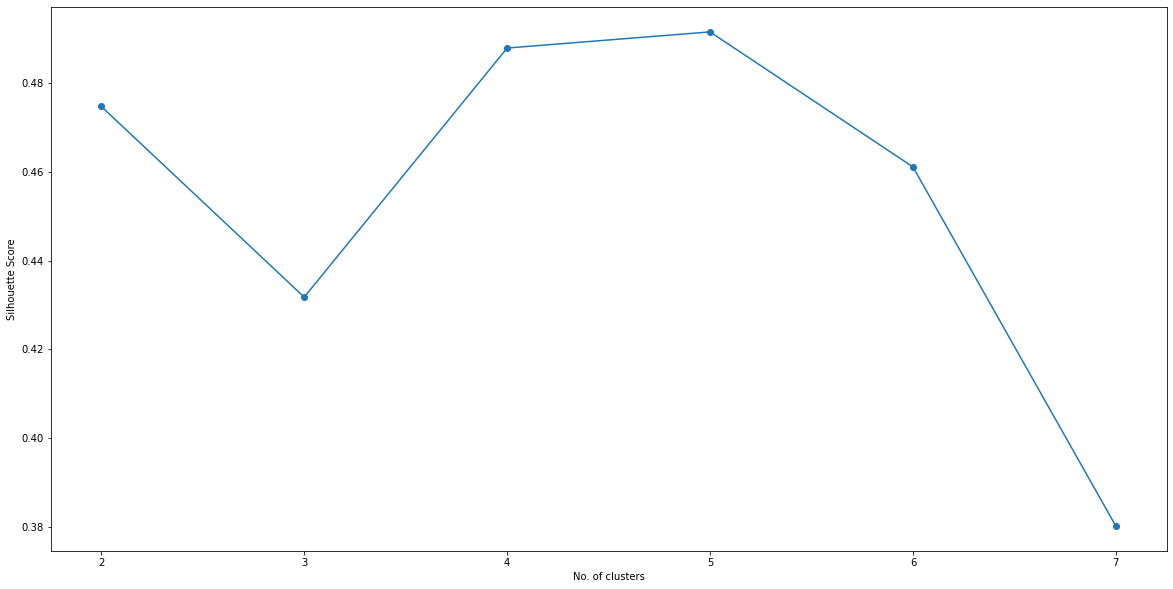

In [70]:
plot(max_range, scores, "No. of clusters", "Silhouette Score")

In [88]:
# set number of clusters
kclusters = 5

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0, init = 'random', n_init = 15).fit(sg_grouped_clustering)

In [89]:
# Drop Region columns
sg_1 = sg.drop(['Region'], axis = 1)

# Drop Northern Island Neighborhood that has no venue
sg_2 = sg_1.drop([26], axis = 0)

In [90]:
# add clustering labels
sg_2['Cluster Labels'] = kmeans.labels_

sg_2.head()

,Planning Areas,Latitude,Longitude,Cluster Labels
0,Ang Mo Kio,1.370080,103.849523,0
1,Bedok,1.323976,103.930216,0
2,Bishan,1.350986,103.848255,0
3,Boon Lay,1.338550,103.705812,0
4,Bukit Batok,1.349057,103.749591,0


In [91]:
# Create new dataframe that include the cluster as well the top 10 venues for each neighborhood
sg_data = sg_2.rename(columns={'Planning Areas':'Neighborhood'}).join(neighborhoods_venues_sorted.set_index('Neighborhood'), on = 'Neighborhood')

sg_data.head(10)

,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Ang Mo Kio,1.370080,103.849523,0,Food Court,Coffee Shop,Fast Food Restaurant,Chinese Restaurant,Supermarket,Japanese Restaurant,Grocery Store,Dessert Shop,Bubble Tea Shop,Bus Stop
1,Bedok,1.323976,103.930216,0,Coffee Shop,Café,Chinese Restaurant,Food Court,Supermarket,Sandwich Place,Japanese Restaurant,Noodle House,Asian Restaurant,Fast Food Restaurant
2,Bishan,1.350986,103.848255,0,Food Court,Coffee Shop,Seafood Restaurant,Chinese Restaurant,Asian Restaurant,Bubble Tea Shop,Thai Restaurant,Café,BBQ Joint,Grocery Store
3,Boon Lay,1.338550,103.705812,0,Japanese Restaurant,Asian Restaurant,Fast Food Restaurant,Chinese Restaurant,Dessert Shop,Food Court,Coffee Shop,Café,Indian Restaurant,Karaoke Bar
4,Bukit Batok,1.349057,103.749591,0,Food Court,Coffee Shop,Fast Food Restaurant,Chinese Restaurant,Grocery Store,Malay Restaurant,Supermarket,Sandwich Place,Stadium,Lottery Retailer
5,Bukit Merah,1.270439,103.828318,3,Bus Station,Clothing Store,Food Court,Coffee Shop,Japanese Restaurant,Multiplex,Fast Food Restaurant,Chinese Restaurant,Department Store,Toy / Game Store
6,Bukit Panjang,1.379149,103.761413,0,Coffee Shop,Asian Restaurant,Fast Food Restaurant,Supermarket,Sushi Restaurant,Indonesian Restaurant,Bus Station,Park,Shopping Mall,Gym
7,Bukit Timah,1.354690,103.776372,2,Trail,Scenic Lookout,Rest Area,Nature Preserve,Lake,Military Base,Australian Restaurant,Park,Arts & Crafts Store,Vegetarian / Vegan Restaurant
8,Central Water Catchment,1.375708,103.801743,4,Café,Gift Shop,Reservoir,Business Service,Food Court,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop
9,Changi,1.351080,103.990064,3,Airport,Airport Lounge,Airport Service,Border Crossing,Bubble Tea Shop,Road,Jewelry Store,General Entertainment,Sandwich Place,Movie Theater


In [110]:
# Visualizing The Cluster

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

map_clusters = folium.Map(location=[sg_lat, sg_long], zoom_start=7, width='100%', height='100%')

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.tab10(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(sg_data['Latitude'], sg_2['Longitude'], sg_2['Planning Areas'], sg_2['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=1).add_to(map_clusters)
       
map_clusters

## Examining Clusters

In [123]:
# Cluster 0

cluster_0 = sg_data.loc[sg_data['Cluster Labels'] == 0, sg_data.columns[[0] + list(range(4, sg_data.shape[1]))]]
cluster_0.head(10)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Ang Mo Kio,Food Court,Coffee Shop,Fast Food Restaurant,Chinese Restaurant,Supermarket,Japanese Restaurant,Grocery Store,Dessert Shop,Bubble Tea Shop,Bus Stop
1,Bedok,Coffee Shop,Café,Chinese Restaurant,Food Court,Supermarket,Sandwich Place,Japanese Restaurant,Noodle House,Asian Restaurant,Fast Food Restaurant
2,Bishan,Food Court,Coffee Shop,Seafood Restaurant,Chinese Restaurant,Asian Restaurant,Bubble Tea Shop,Thai Restaurant,Café,BBQ Joint,Grocery Store
3,Boon Lay,Japanese Restaurant,Asian Restaurant,Fast Food Restaurant,Chinese Restaurant,Dessert Shop,Food Court,Coffee Shop,Café,Indian Restaurant,Karaoke Bar
4,Bukit Batok,Food Court,Coffee Shop,Fast Food Restaurant,Chinese Restaurant,Grocery Store,Malay Restaurant,Supermarket,Sandwich Place,Stadium,Lottery Retailer
6,Bukit Panjang,Coffee Shop,Asian Restaurant,Fast Food Restaurant,Supermarket,Sushi Restaurant,Indonesian Restaurant,Bus Station,Park,Shopping Mall,Gym
11,Choa Chu Kang,Coffee Shop,Fast Food Restaurant,Food Court,Café,Noodle House,Supermarket,Chinese Restaurant,Gym,Sandwich Place,Thai Restaurant
12,Clementi,Food Court,Coffee Shop,Chinese Restaurant,Asian Restaurant,Indian Restaurant,Dessert Shop,Bakery,Supermarket,Café,Gym
14,Geylang,Chinese Restaurant,Noodle House,Asian Restaurant,Food Court,Vegetarian / Vegan Restaurant,Fast Food Restaurant,Supermarket,Steakhouse,Seafood Restaurant,Dessert Shop
15,Hougang,Coffee Shop,Food Court,Chinese Restaurant,Fast Food Restaurant,Asian Restaurant,Supermarket,Café,Vegetarian / Vegan Restaurant,Playground,Metro Station


In [77]:
cluster_0.iloc[:,1].value_counts()

#Conclusion : Cluster 0 dominated by Food Court, Coffee Shop & Thematic Restaurant

Food Court              8
Chinese Restaurant      7
Coffee Shop             6
Asian Restaurant        3
Japanese Restaurant     1
Campground              1
Noodle House            1
Café                    1
Fast Food Restaurant    1
Name: 1st Most Common Venue, dtype: int64

In [78]:
# Cluster 1

cluster_1 = sg_data.loc[sg_data['Cluster Labels'] == 1, sg_data.columns[[0] + list(range(4, sg_data.shape[1]))]]
cluster_1.head(10)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
10,Changi Bay,Boat or Ferry,Harbor / Marina,Pizza Place,Yoga Studio,Food,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop
51,Western Islands,Resort,Harbor / Marina,Boat or Ferry,Scenic Lookout,Yoga Studio,Filipino Restaurant,Exhibit,Farm,Farmers Market,Fast Food Restaurant
52,Western Water Catchment,Gun Range,Gym,Train Station,Yoga Studio,Fish & Chips Shop,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Flea Market


In [79]:
cluster_1.iloc[:,1].value_counts()

#Conclusion : Cluster 1 dominated by venues type towards waterfront activities such as Boat/Ferry, Resort, Pool, Harbor / Marina

Boat or Ferry    1
Resort           1
Gun Range        1
Name: 1st Most Common Venue, dtype: int64

In [80]:
# Cluster 2

cluster_2 = sg_data.loc[sg_data['Cluster Labels'] == 2, sg_data.columns[[0] + list(range(4, sg_data.shape[1]))]]
cluster_2.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
7,Bukit Timah,Trail,Scenic Lookout,Rest Area,Nature Preserve,Lake,Military Base,Australian Restaurant,Park,Arts & Crafts Store,Vegetarian / Vegan Restaurant
43,Southern Islands,Trail,Dry Cleaner,Yoga Studio,Flea Market,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Food


In [81]:
cluster_2.iloc[:,1].value_counts()

#Conclusion : Cluster 2 dominated by venues type towards natural & pyshical activities such as hiking trail, scenic lookout, park, lake, etc

Trail    2
Name: 1st Most Common Venue, dtype: int64

In [121]:
# Cluster 3

cluster_3 = sg_data.loc[sg_data['Cluster Labels'] == 3, sg_data.columns[[0] + list(range(4, sg_data.shape[1]))]]
cluster_3.head(10)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,Bukit Merah,Bus Station,Clothing Store,Food Court,Coffee Shop,Japanese Restaurant,Multiplex,Fast Food Restaurant,Chinese Restaurant,Department Store,Toy / Game Store
9,Changi,Airport,Airport Lounge,Airport Service,Border Crossing,Bubble Tea Shop,Road,Jewelry Store,General Entertainment,Sandwich Place,Movie Theater
13,Downtown Core,Hotel,Waterfront,Italian Restaurant,Event Space,Japanese Restaurant,Boutique,Lounge,Buffet,Dim Sum Restaurant,Theater
16,Jurong East,Chinese Restaurant,Café,Japanese Restaurant,Coffee Shop,Food Court,Shopping Mall,Clothing Store,Bus Station,Korean Restaurant,Multiplex
19,Lim Chu Kang,Farm,Zoo Exhibit,Vegetarian / Vegan Restaurant,Theme Park Ride / Attraction,Fish & Chips Shop,Exhibit,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant
20,Mandai,Cosmetics Shop,Speakeasy,Halal Restaurant,Trail,Chinese Restaurant,Yoga Studio,Fish & Chips Shop,Farm,Farmers Market,Fast Food Restaurant
21,Marina East,Scenic Lookout,Garden,Racetrack,Seafood Restaurant,Art Gallery,Golf Course,Botanical Garden,Waterfront,Bridge,Park
22,Marina South,Japanese Restaurant,Garden,Hotel,Boutique,Coffee Shop,Scenic Lookout,Waterfront,Bridge,Boat or Ferry,Theater
23,Marine Parade,Chinese Restaurant,Noodle House,Hotel,Indian Restaurant,Asian Restaurant,Coffee Shop,Japanese Restaurant,Bar,Multiplex,Massage Studio
24,Museum,Hotel,Japanese Restaurant,Café,Shopping Mall,Coffee Shop,Restaurant,Bubble Tea Shop,Movie Theater,Korean Restaurant,Steakhouse


In [83]:
cluster_3.iloc[:,1].value_counts()

#Conclusion : Cluster 3 dominated by facilities that support tourist activities such as Airport, Bus Station, Hotel, Cafe, Restaurant, etc

Hotel                     4
Chinese Restaurant        2
Café                      2
Japanese Restaurant       2
Indian Restaurant         1
Airport                   1
Multiplex                 1
Bus Station               1
Farm                      1
Cruise Ship               1
Furniture / Home Store    1
Scenic Lookout            1
Cosmetics Shop            1
Boutique                  1
Name: 1st Most Common Venue, dtype: int64

In [93]:
# Cluster 4

cluster_4 = sg_data.loc[sg_data['Cluster Labels'] == 4, sg_data.columns[[0] + list(range(4, sg_data.shape[1]))]]
cluster_4.head(10)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,Central Water Catchment,Café,Gift Shop,Reservoir,Business Service,Food Court,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop
37,Seletar,Café,Gastropub,Airport Service,Airport Terminal,Harbor / Marina,Resort,Boat or Ferry,Yoga Studio,Flea Market,Fast Food Restaurant
44,Straits View,Cruise Ship,Diner,Café,Pier,Food,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop


In [94]:
cluster_4.iloc[:,1].value_counts()

#Conclusion : Cluster 4 dominated by venues type towards cafe and cruise ship oriented activities

Café           2
Cruise Ship    1
Name: 1st Most Common Venue, dtype: int64

In [113]:
cluster_0.shape

(27, 11)

In [114]:
cluster_1.shape

(3, 11)

In [115]:
cluster_2.shape

(2, 11)

In [116]:
cluster_3.shape

(20, 11)

In [117]:
cluster_4.shape

(3, 11)